In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *
from training_func import *

In [2]:
torch.cuda.is_available()

True

In [2]:
G_21 = xr.open_dataset("../dataset/G_21_subset_imputed.nc")
G_21 = G_21.to_array().values.squeeze(0)
G_21.shape

(3565, 102484)

In [2]:
real_data_index = False
n = 300
p = 1000
p_causal = 30
batch_size = 50
r_batch = batch_size/n
device = 'cpu'
if real_data_index:
    np.random.seed(seed = None)
    p_max = G_21.shape[1]
    n_max = G_21.shape[0]
    SNP_index = np.random.choice(p_max,size = p, replace = False)
    subject_index =  np.random.choice(n_max,size = n, replace = False)
    G_21_sub = G_21[np.ix_(subject_index, SNP_index)]
    print(G_21_sub.shape)
    freq_snp = G_21_sub.mean(axis = 0)/2
    sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
    G_21_sub = (G_21_sub-2*freq_snp)/sd_snp
    Xs = [G_21_sub]
    n = Xs[0].shape[0]
    p = Xs[0].shape[1]
else:
    Xs = None
print(r_batch)

0.16666666666666666


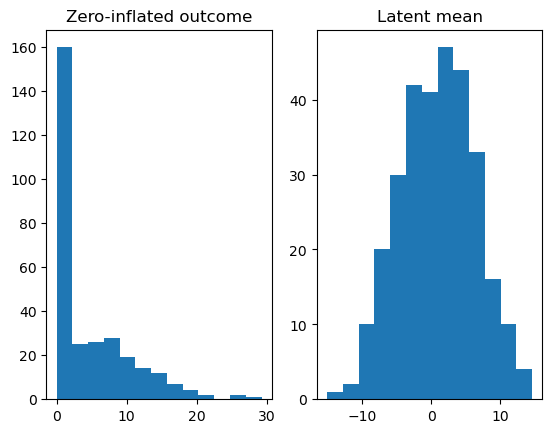

------------------------------------
genetic variance is 29.099771827702686
total variance is96.99923942567563
heritability is 0.3
------------------------------------


In [3]:
rho = 0.6
var = 1
n_matrix = 1
h = 0.3
beta_bias = 1
sim_class = data_sim.sim_tobit_data(n = n, p = p, p_causal = p_causal, rho = rho, var = var, n_matrix = n_matrix,h = h, bias = beta_bias, Xs = Xs, scale_lambda =None)
z, X, Xs, latent_mean, var_genetic, var_total, true_beta, y_star = sim_class.gen_data(seed = None)
data_sim.show_sim(z, latent_mean, var_total)

In [10]:
sim_data = Sim_Dataset(X.double().to(device),y_star.double().to(device))
sim_data_loader = DataLoader(sim_data, batch_size = batch_size)
model = linear_slab_spike(p = p, n_total = n, init_pi_local = 0.5, init_pi_global = 0.1, init_beta_var = 2, init_noise_var = 0.1,
                         gumbel_softmax_temp = 1, gumbel_softmax_hard = False, 
                          a1= 0.1, a2=1, init_a3= 0.1, init_a4 = 0.1,
                          b1 = 1.1, b2 = 1.1, init_b3 = 1.1, init_b4 = 1.1, n_E = 1
                          , prior_sparsity = True, prior_sparsity_beta = True, device = device
                         ).double().to(device)
optimizer = torch.optim.Adam(
    [{'params': model.beta_mu},
     {'params': model.beta_log_var},
     {'params': model.logit_pi_local, 'lr': 0.5},
     {'params': model.log_a3},
     {'params': model.log_a4},
     {'params': model.log_b3},
     {'params': model.log_b4},
     {'params': model.bias},
     {'params': model.logit_pi_global, 'lr':0.5},
     {'params': model.beta_log_var_prior},
     {'params': model.log_var_noise},
    ],
    lr = 0.05)

At iteration 0, the loss is 5299.577312674596
At iteration 1000, the loss is 224.0623630250829


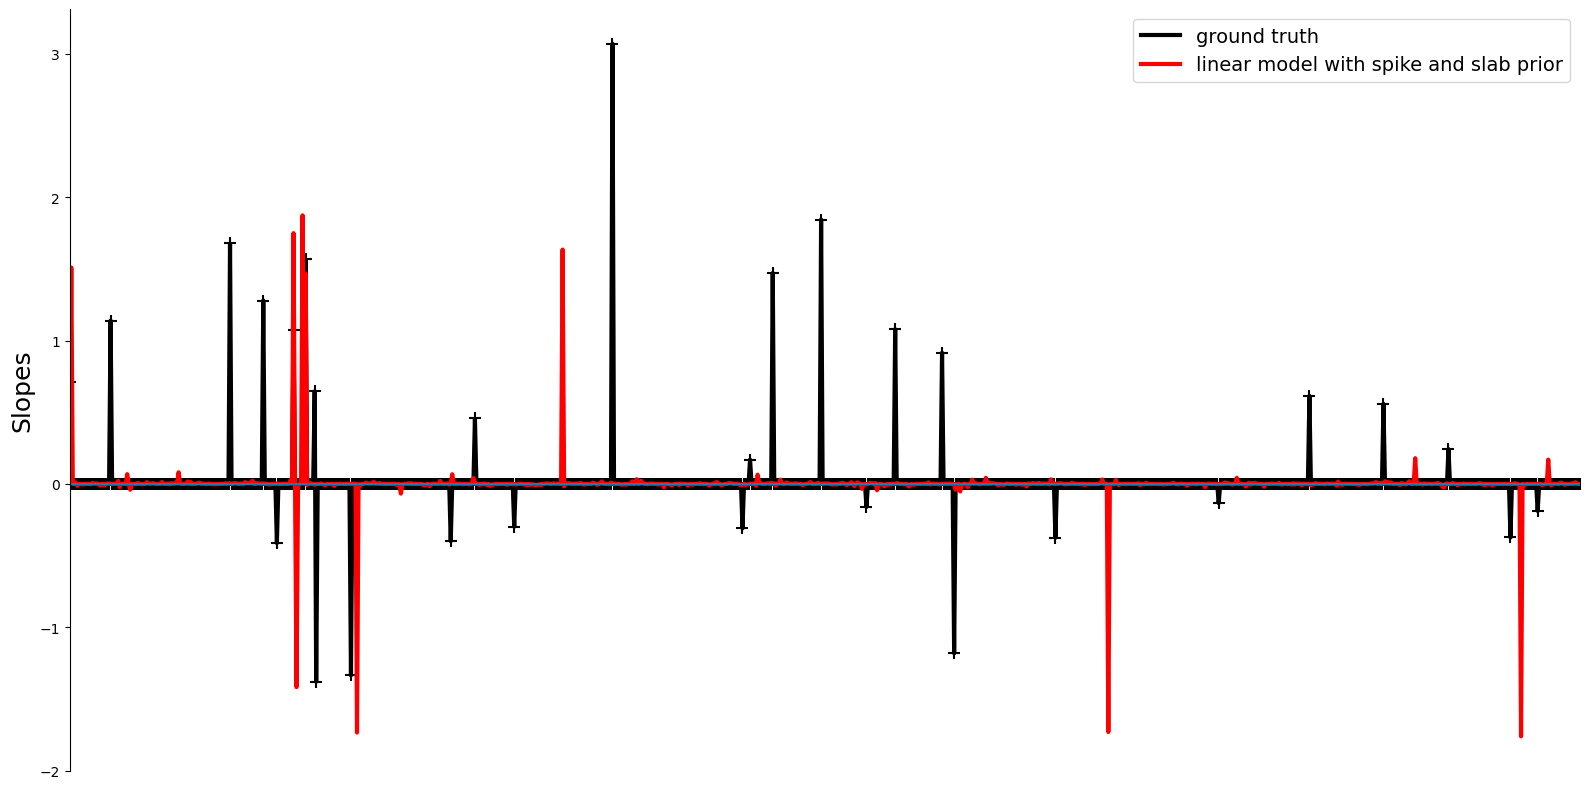

In [11]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
t = 100 #number of moving averages
patience = 100# patience
_, result_dict = train_and_infer(model = model, optimizer = optimizer, sim_data_loader = sim_data_loader, lr_scheduler = lr_scheduler, t = t, patience = patience,X = X, plot = True, true_beta = true_beta, verbose = True)

In [13]:
result_dict

{'mean_h_est': [0.3863316841977167],
 'h_est_upper': [0.5855921988581391],
 'h_est_lower': [0.21759958737321222],
 'mean_var_genetic': [44.01888939266896],
 'noise_var': [67.72431664170601],
 'global_pi': [0.014502424793442006],
 'global_pi_upper': [0.022688904722105108],
 'global_pi_lower': [0.008407159192191252]}

In [9]:
p_causal/p

0.03

In [25]:
# torch.sum(torch.sigmoid(model.logit_pi_local)>0.9)/p
print(torch.max(torch.sigmoid(model.logit_pi_local)))
print(torch.min(torch.sigmoid(model.logit_pi_local)))
# torch.min(model.beta_mu)
# torch.max(model.beta_mu)
torch.exp(model.beta_log_var)
print(torch.mean(torch.exp(model.beta_log_var)))

tensor(1.0000, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(6.4280e-09, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.4833, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [9]:
c = torch.exp(best_model.log_c).detach().numpy()
d = torch.exp(best_model.log_d).detach().numpy()
# c = 10
# d = 10
print(c)
print(d)
posterior = np.random.beta(c,d,size = (5000,))
np.median(posterior)
print(np.quantile(posterior, q = 0.025))
print(np.quantile(posterior, q = 0.975))
plt.hist(posterior)
plt.show()

NameError: name 'best_model' is not defined